# MODEL TRAINING

In [1]:
import warnings
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.preprocessing import image
from keras.applications import inception_v3, xception, nasnet

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split as tts

SEED = 42
POOL = 'avg'
data = None

Using TensorFlow backend.


## Preparations and Functions

In [2]:
"""Creating dirs for saving features and submissions"""
if not os.path.exists('./output/'):
    os.mkdir('./output/')
if not os.path.exists('./features/'):
    os.mkdir('./features/')

"""Deleting some of the previously generated features to show working process of keras predicting"""
if os.path.exists('./features/test_1_299_xception_bf.npy'):
    os.remove('./features/test_1_299_xception_bf.npy')

"""Used models for bottleneck feature predicting"""
models = {
    'inception': {
        'model': inception_v3.InceptionV3,
        'preprocessor': inception_v3.preprocess_input,
        'shape': (299,299,3)
    },
    'xception': {
        'model': xception.Xception,
        'preprocessor': xception.preprocess_input,
        'shape': (299,299,3)
    },
    'nasnet': {
        'model': nasnet.NASNetLarge,
        'preprocessor': nasnet.preprocess_input,
        'shape': (299,299,3) #(331,331,3) should be better, but my RAM is not enough
    }
}

def preds_by_probs(p):
    """
     INPUT: probabilities of classes
    OUTPUT: indices of classes 
    """
    return p.argmax(axis=1).astype(np.int32)

def clean_probs(p, n=11):
    """
     INPUT: probabilities of classes and number of classes to keep
    OUTPUT: probabilities of classes, where all probs except top-N added to top-1 class
    """
    pp = np.zeros(p.shape, dtype=np.float64)
    
    for i in range(len(p)):
        ind = p[i].argpartition(-n)[-n:]
        pp[i][[ind]] = p[i][ind]
    
    diff = 1 - pp.sum(axis=1)
    
    for r, c in enumerate(preds_by_probs(p)):
        pp[r][c] += diff[r]
    return pp

def read_img(img_id, batch='train', size=(299, 299)):
    """
    Read image by img_id from batch-dir, resize it to given shape 
    """
    assert batch == 'train' or batch == 'test', 'batch should be "train" or "test"'
    
    img = image.load_img('./input/{}/{}.jpg'.format(batch, img_id), target_size=size)
    return image.img_to_array(img)

def load_imgs(df, shape, batch='train', idx_arr=None):
    """
     INPUT:  dataframe with 'id' column of image ids
             shape of the image for resizing
             batch-dir
             array of indices to load for 'train' batch-dir
    OUTPUT:  np.array of all images
    """
    assert batch == 'train' or batch == 'test', 'batch should be "train" or "test"'
    
    if idx_arr is None:
        qty = len(df)
        idx_arr = df.index
    else:
        qty = len(idx_arr)
    
    if batch == 'train':
        X = np.zeros(((qty,)+shape), dtype=np.float32)
        for i in tqdm(range(len(idx_arr))):
            X[i] = read_img(df.id[idx_arr[i]], batch=batch, size=shape[:2])
    else:
        idxs = [idx_arr[:len(idx_arr)//2], idx_arr[-len(idx_arr)//2:]]

        X = []
        for idx in idxs:
            X.append(np.zeros(((len(idx),)+shape), dtype=np.float32))

        for j, idx in enumerate(idxs):
            for i in tqdm(range(len(idx))):
                X[j][i] = read_img(df.id[idx[i]], batch=batch, size=shape[:2])        

    return X

def get_data(shape, batch='train', data=None, only_y=False):
    """
     INPUT:  shape of the image for resizing
             batch-dir
             dict if the correct data is already loaded
             flag if need only labels data for 'train' batch-dir
    OUTPUT:  dict with all the needed data for current batch
    """
    assert batch == 'train' or batch == 'test', 'batch should be "train" or "test"'
    
    if (data is None) or ('shape' in data and data['shape'] != shape) or ('batch' in data and data['batch'] != batch):
        data = {'shape': shape, 'batch': batch}
    else:
        return data
    
    if batch == 'train':
        l = pd.read_csv('./input/labels.csv')
        y = pd.get_dummies(l.breed).values
        
        tridx, vaidx = tts(range(len(l)), test_size=2345, stratify=l.breed, random_state=SEED)
        data['y_train'], data['y_valid'] = y[[tridx]], y[[vaidx]]
        if only_y: return data
        
        data['X_train'] = load_imgs(l, shape, batch, tridx)
        data['X_valid'] = load_imgs(l, shape, batch, vaidx)    
        print('train set shape: {}\tmemory: {:,.2f} MB'.format(data['X_train'].shape, data['X_train'].nbytes/2**20))
        print('valid set shape: {}\tmemory: {:,.2f} MB'.format(data['X_valid'].shape, data['X_valid'].nbytes/2**20))
    else:
        l = pd.read_csv('./input/sample_submission.csv')
        
        data['X_test'] = load_imgs(l, shape, batch)
        for i, Xte in enumerate(data['X_test']):
            print('test set batch {} shape: {}\tmemory: {:,.2f} MB'.format(i, Xte.shape, Xte.nbytes/2**20))
        
        data['y_cols'] = l.columns
        
        l = l.id.values
        data['y_test'] = l.reshape(l.shape[0], 1)
        
        l = pd.read_csv('./input/labels.csv')
        y = pd.get_dummies(l.breed).as_matrix()
        
        tridx, vaidx = tts(range(len(l)), test_size=2345, stratify=np.array(l.breed), random_state=SEED)
        data['y_train'], data['y_valid'] = y[[tridx]], y[[vaidx]]
        
    return data

def generate_features(info, X, y, datagen, batch='train'):
    """
    Predicting bottleneck features for given batch of data and data generator by model from info
    """
    assert batch == 'train' or batch == 'valid' or batch == 'test', 'batch should be "train", "valid" or "test"'

    print('\tgenerating {} bottleneck features...'.format(batch))
    
    print('\t\tdatagen initialising')
    datagen.preprocessing_function = info['preprocessor']
    generator = datagen.flow(X, y, shuffle=False, seed=SEED)
    
    print('\t\tmodel loading')
    bottleneck_model = info['model'](include_top=False, input_shape=info['shape'], pooling=POOL)
    
    print('\tpredicting features')
    return bottleneck_model.predict_generator(generator)

## Xception, Inception V3 and NASNetLarge bottleneck features >> LogReg classifier

Image recognition state-of-the art approaches contains using of very deep and large CNN's. Moreover this NN trained on huge amounts of images.
We don't have the time (7 days) or resourses (10,222 pics) for this kind of approach, but luckily we can use transfer learning - take some of the popular NN's w/out top layers and generate so called bottleneck features on given imageset to use it as output for our task.

Here we train simple sklearn LogReg because it's fast while producing good results. My notebook have considerably small amount of memory (8Gb) that's why I save generated features and load this files instead of calculating all the features by GPU. If the features wasn't saved beforehand, my Jupyter notebook crashes due to unknown or memory issues during NASNet step or while reading new imageset. I tried read imageset into np.memmap arrays, but it also doesn't help and even added issues w/ local drive.

In [3]:
for model, info in models.items():
    
    data = get_data(info['shape'], 'train', data)
    print('\npredicting {}'.format(model))

    trf = './features/train_{}_{}_bf.npy'.format(info['shape'][0], model)
    if os.path.exists(trf):
        print('\tloading previously generated train features')
        tr_bf = np.load(trf)        
    else:
        tr_datagen = image.ImageDataGenerator(rotation_range=30,
                                              width_shift_range=0.2,
                                              height_shift_range=0.2,
                                              horizontal_flip = 'true')     
        tr_bf = generate_features(info, data['X_train'], data['y_train'], tr_datagen, batch='train')
        np.save(trf, tr_bf)
        
    vaf = './features/valid_{}_{}_bf.npy'.format(info['shape'][0], model)
    if os.path.exists(vaf):
        print('\tloading previously generated valid features')
        va_bf = np.load(vaf)
    else:
        va_datagen = image.ImageDataGenerator()
        va_bf = generate_features(info, data['X_valid'], data['y_valid'], va_datagen, batch='valid')
        np.save(vaf, va_bf)
    
    lytr = (data['y_train'] * range(data['y_train'].shape[1])).sum(axis=1)
    lyva = (data['y_valid'] * range(data['y_valid'].shape[1])).sum(axis=1)
    
    print('\tdoing some LogReg on features')
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
    logreg.fit(tr_bf, lytr)

    info['train_probs'] = logreg.predict_proba(tr_bf)
    np.save('./features/train_{}_probs.npy'.format(model), info['train_probs'])
    info['valid_probs'] = logreg.predict_proba(va_bf)
    np.save('./features/valid_{}_probs.npy'.format(model), info['valid_probs'])
    
    print('\t\tvalidation {} LogLoss:\t{:.4f}'.format(model, log_loss(data['y_valid'], info['valid_probs'])))
    print('\t\tvalidation {} Accuracy:\t{:.2f}%'.format(model, 100*logreg.score(va_bf, lyva)))

100%|██████████████████████████████████████████████████████████████████████████████| 2345/2345 [00:38<00:00, 60.21it/s]


train set shape: (7877, 299, 299, 3)	memory: 8,059.06 MB
valid set shape: (2345, 299, 299, 3)	memory: 2,399.20 MB

predicting inception
	loading previously generated train features
	loading previously generated valid features
	doing some LogReg on features
		validation inception LogLoss:	0.3364
		validation inception Accuracy:	90.32%

predicting xception
	loading previously generated train features
	loading previously generated valid features
	doing some LogReg on features
		validation xception LogLoss:	0.3287
		validation xception Accuracy:	90.23%

predicting nasnet
	loading previously generated train features
	loading previously generated valid features
	doing some LogReg on features
		validation nasnet LogLoss:	0.2894
		validation nasnet Accuracy:	92.15%


## Xception, Inception V3 and NASNetLarge bottleneck features >> FC layers

Here we try to train simple architecture NN in place of LogReg. My GPU is GTX 1050 Ti and results are quick enough, but not very satisfactory.

In [4]:
%%time
data = get_data(shape=(0,0,0), only_y=True)

for model, info in models.items():
    print('\npredicting {}'.format(model))
    
    trf = './features/train_{}_{}_bf.npy'.format(info['shape'][0], model)
    vaf = './features/valid_{}_{}_bf.npy'.format(info['shape'][0], model)
    tr_bf = np.load(trf)
    va_bf = np.load(vaf)
    
    nnmodel = Sequential()
    nnmodel.add(Dense(1024, activation='relu', input_shape=(tr_bf.shape[1],)))
    nnmodel.add(Dropout(.25))
    nnmodel.add(Dense(512, activation='relu'))
    nnmodel.add(Dropout(.2))
    nnmodel.add(Dense(256, activation='relu'))
    nnmodel.add(Dense(120, activation='relu'))
    nnmodel.add(Dense(120, activation='softmax'))
    nnmodel.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"]) 

    print('doing some neural learning...')
    history = nnmodel.fit(tr_bf, data['y_train'], steps_per_epoch=1, epochs=100,\
              validation_data=(va_bf, data['y_valid']), validation_steps=1, verbose=0)
    
    info['train_probs'] = nnmodel.predict(tr_bf)
    np.save('./features/train_{}_nn_probs.npy'.format(model), info['train_probs'])
    
    info['valid_probs'] = nnmodel.predict(va_bf)
    np.save('./features/valid_{}_nn_probs.npy'.format(model), info['valid_probs'])
    
    tr_preds = preds_by_probs(info['train_probs'])
    va_preds = preds_by_probs(info['valid_probs'])
    lytr = (data['y_train'] * range(data['y_train'].shape[1])).sum(axis=1)
    lyva = (data['y_valid'] * range(data['y_valid'].shape[1])).sum(axis=1)
    
    print('\t\ttrain      {} LogLoss:\t{:.4f}'.format(model, log_loss(data['y_train'], info['train_probs'])))
    print('\t\ttrain      {} Accuracy:\t{:.2f}%'.format(model, 100*accuracy_score(lytr, tr_preds)))
    print('\t\tvalidation {} LogLoss:\t{:.4f}'.format(model, log_loss(data['y_valid'], info['valid_probs'])))
    print('\t\tvalidation {} Accuracy:\t{:.2f}%'.format(model, 100*accuracy_score(lyva, va_preds)))


predicting inception
doing some neural learning...
		train      inception LogLoss:	0.0454
		train      inception Accuracy:	99.04%
		validation inception LogLoss:	0.3934
		validation inception Accuracy:	88.32%

predicting xception
doing some neural learning...
		train      xception LogLoss:	0.0499
		train      xception Accuracy:	99.01%
		validation xception LogLoss:	0.3916
		validation xception Accuracy:	88.61%

predicting nasnet
doing some neural learning...
		train      nasnet LogLoss:	0.0181
		train      nasnet Accuracy:	99.59%
		validation nasnet LogLoss:	0.3828
		validation nasnet Accuracy:	91.09%
Wall time: 53 s
Parser   : 135 ms


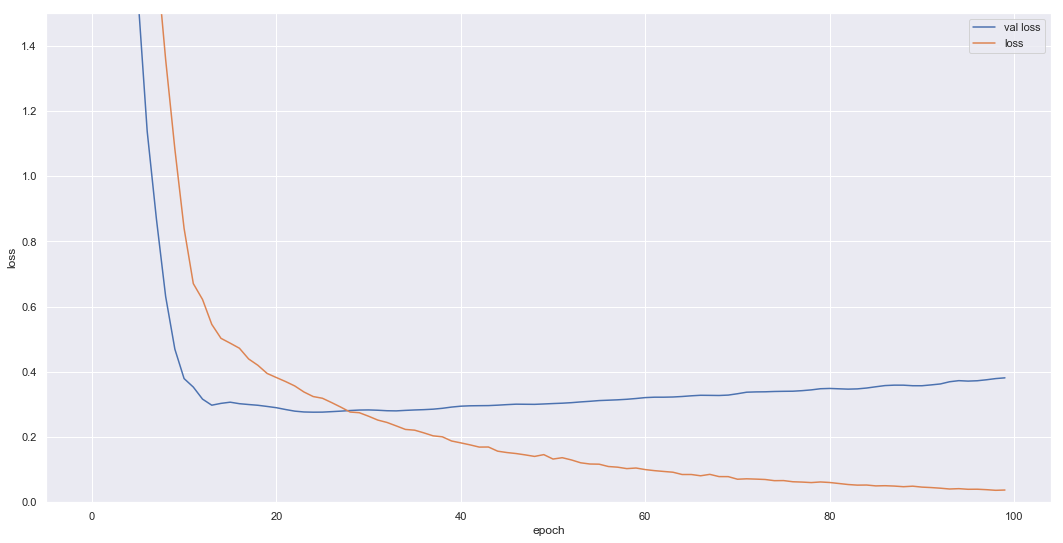

In [5]:
h = pd.DataFrame(history.history)
h['epoch'] = h.index

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
ax = sns.lineplot(x='epoch', y='val_loss', data=h)
ax = sns.lineplot(x='epoch', y='loss', data=h)
ax.legend(handles=ax.lines, labels=['val loss','loss'])
ax.set_ylim(0,1.5)
plt.show()

If we look into history of NN training we may notice that val_loss gradually increasing after some number of epochs, which is clear sign of overfitting. NN should be very robust to this issue, but only while we have a lot of data to train and validate on, which is not the case for us.

NN perfomance isn't bad, but in needed some stop criteria on epochs and later on we will not use it for submission.

## Predicting by using all bottleneck features from models >> LogReg classifier

Here we combine all the generated bottleneck features generated before and then predicting breed classes by LogReg.

The general idea is that in all models there are some usefull features, so by combining them we may gain increace in prediction perfomance.

In [6]:
%%time

train_all_bf, valid_all_bf = [], []
data = get_data(shape=(0,0,0), only_y=True)
for model, info in models.items():
    trf, vaf = './features/train_'+str(info['shape'][0])+'_'+model+'_bf.npy', './features/valid_'+str(info['shape'][0])+'_'+model+'_bf.npy'
    train_all_bf.append(np.load(trf))
    valid_all_bf.append(np.load(vaf))

train_all_bf = np.hstack(train_all_bf)
valid_all_bf = np.hstack(valid_all_bf)

lytr = (data['y_train'] * range(data['y_train'].shape[1])).sum(axis=1)
lyva = (data['y_valid'] * range(data['y_valid'].shape[1])).sum(axis=1)

print('doing some LogReg on features')
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_all_bf, lytr)

valid_all_probs = logreg.predict_proba(valid_all_bf)
train_all_probs = logreg.predict_proba(train_all_bf)

np.save('./features/valid_all_probs.npy', valid_all_probs)
np.save('./features/train_all_probs.npy', train_all_probs)

print('\ttrain ALL LogLoss:\t\t{:.4f}'.format(log_loss(data['y_train'], train_all_probs)))
print('\ttrain ALL Accuracy:\t\t{:.2f}%'.format(100*logreg.score(train_all_bf, lytr)))
print('\tvalid ALL LogLoss:\t\t{:.4f}'.format(log_loss(data['y_valid'], valid_all_probs)))
print('\tvalid ALL Cleaned LogLoss:\t{:.4f}'.format(log_loss(data['y_valid'], clean_probs(valid_all_probs, 12))))
print('\tvalid ALL Accuracy:\t\t{:.2f}%'.format(100*logreg.score(valid_all_bf, lyva)))

doing some LogReg on features
	train ALL LogLoss:		0.0068
	train ALL Accuracy:		100.00%
	valid ALL LogLoss:		0.2608
	valid ALL Cleaned LogLoss:	0.2588
	valid ALL Accuracy:		92.75%
Wall time: 47.5 s


## Predicting by using all bottleneck features from models >> FC layers

Same idea as above, but in place of LogReg we predict breed classes by using trained on our dataset simple architecture NN.

In [7]:
%%time

train_all_bf, valid_all_bf = [], []
data = get_data(shape=(0,0,0), only_y=True)
for model, info in models.items():
    trf, vaf = './features/train_'+str(info['shape'][0])+'_'+model+'_bf.npy', './features/valid_'+str(info['shape'][0])+'_'+model+'_bf.npy'
    train_all_bf.append(np.load(trf))
    valid_all_bf.append(np.load(vaf))

train_all_bf = np.hstack(train_all_bf)
valid_all_bf = np.hstack(valid_all_bf)

model = Sequential()
model.add(Dense(4096, activation='relu', input_shape=(8128,)))
model.add(Dropout(.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(120, activation='softmax'))
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"]) 
model.summary()

history = model.fit(train_all_bf, data['y_train'], steps_per_epoch=2, epochs=50,\
          validation_data=(valid_all_bf, data['y_valid']), validation_steps=1, verbose=2)

valid_all_nn_probs = model.predict(valid_all_bf, batch_size=256)
valid_all_nn_preds = preds_by_probs(valid_all_nn_probs)
train_all_nn_probs = model.predict(train_all_bf, batch_size=256)
train_all_nn_preds = preds_by_probs(train_all_nn_probs)

np.save('./features/valid_all_nn_probs.npy', valid_all_nn_probs)
np.save('./features/train_all_nn_probs.npy', train_all_nn_probs)

lytr = (data['y_train'] * range(data['y_train'].shape[1])).sum(axis=1)
lyva = (data['y_valid'] * range(data['y_valid'].shape[1])).sum(axis=1)

print('\ttrain ALL LogLoss:\t\t{:.4f}'.format(log_loss(data['y_train'], train_all_nn_probs)))
print('\ttrain ALL Accuracy:\t\t{:.2f}%'.format(100*accuracy_score(lytr, train_all_nn_preds)))
print('\tvalid ALL LogLoss:\t\t{:.4f}'.format(log_loss(data['y_valid'], valid_all_nn_probs)))
print('\tvalid ALL Accuracy:\t\t{:.2f}%'.format(100*accuracy_score(lyva, valid_all_nn_preds)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 4096)              33296384  
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               2097664   
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 120)               30840     
Total params: 35,556,216
Trainable params: 35,556,216
Non-trainable params: 0
________________________________________________________________

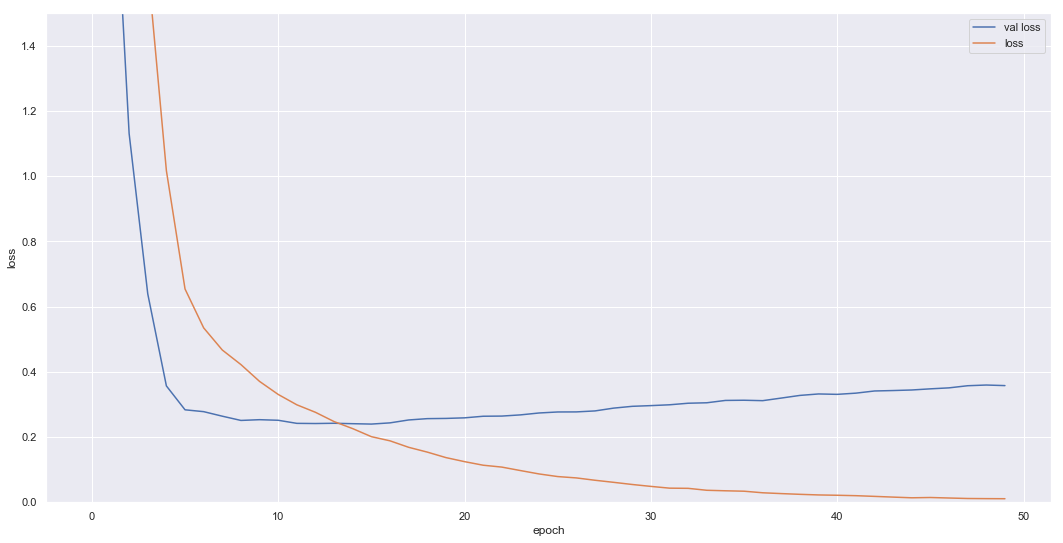

In [8]:
h = pd.DataFrame(history.history)
h['epoch'] = h.index

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
ax = sns.lineplot(x='epoch', y='val_loss', data=h)
ax = sns.lineplot(x='epoch', y='loss', data=h)
ax.legend(handles=ax.lines, labels=['val loss','loss'])
ax.set_ylim(0,1.5)
plt.show()

Once again, NN performs not bad, but have tendency to overfit.

Without simple stop criteria in our later work and submission we will stick to NN bottleneck features & LogReg combo.

## Predicting by averaging predictions between all models

Here we combine all the predicted probabilities by NN>>LogReg models above and then averaging them. This is so called ensemble in general tends to perform better than any single model in it.

In [9]:
valid_avg_probs, train_avg_probs, weights = [], [], []
for model, info in models.items():
    valid_avg_probs.append(info['valid_probs'])
    train_avg_probs.append(info['train_probs'])
    weights.append(1)

train_avg_probs = np.average(train_avg_probs, axis=0, weights=weights)
valid_avg_probs = np.average(valid_avg_probs, axis=0, weights=weights)

np.save('./features/valid_avg_probs.npy', valid_avg_probs)
np.save('./features/train_avg_probs.npy', train_avg_probs)

valid_avg_preds = preds_by_probs(valid_avg_probs)
train_avg_preds = preds_by_probs(train_avg_probs)

lytr = (data['y_train'] * range(data['y_train'].shape[1])).sum(axis=1)
lyva = (data['y_valid'] * range(data['y_valid'].shape[1])).sum(axis=1)

print('train AVG LogLoss:\t\t{:.4f}'.format(log_loss(data['y_train'], train_avg_probs)))
print('train AVG Accuracy:\t\t{:.2f}%'.format(100*accuracy_score(lytr, train_avg_preds)))
print('valid AVG LogLoss:\t\t{:.4f}'.format(log_loss(data['y_valid'], valid_avg_probs)))
print('valid AVG Cleaned LogLoss:\t{:.4f}'.format(log_loss(data['y_valid'], clean_probs(valid_avg_probs, 10))))
print('valid AVG Accuracy:\t\t{:.2f}%'.format(100*accuracy_score(lyva, valid_avg_preds)))

train AVG LogLoss:		0.0344
train AVG Accuracy:		99.57%
valid AVG LogLoss:		0.2559
valid AVG Cleaned LogLoss:	0.2631
valid AVG Accuracy:		91.94%


The results are better in comparison with using all bottleneck features in LogReg that's why we will stick to this approach in our submission.

## Submission preparing for avg ensemble

Here we will read all the previously generated&saved train/validation bottleneck features as well as new test bottleneck features for purpose of training new LogReg model on all the train images and results predicting for test images in given format.

In [10]:
%%time

for model, info in models.items():
    
    data = get_data(info['shape'], 'test', data)
    
    print('\npredicting {}'.format(model))
    te_datagen = image.ImageDataGenerator()
    
    te_bf = []
    for i, Xte in enumerate(data['X_test']):
        tef = './features/test_{}_{}_{}_bf.npy'.format(i, info['shape'][0], model)
        if os.path.exists(tef):
            print('\tload previously generated test batch {} of features'.format(i))
            te_bf.append(np.load(tef))
        else:
            bf = generate_features(info, Xte, None, te_datagen, batch='test')
            np.save(tef, bf)
            te_bf.append(bf)
    
    te_bf = np.vstack(te_bf)
    
    trf = './features/train_{}_{}_bf.npy'.format(info['shape'][0], model)
    vaf = './features/valid_{}_{}_bf.npy'.format(info['shape'][0], model)
    tr_bf = np.vstack([np.load(trf), np.load(vaf)])
    ytr = np.vstack([data['y_train'], data['y_valid']])
    
    print('\tdoing some LogReg on features')
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
    logreg.fit(tr_bf, (ytr * range(ytr.shape[1])).sum(axis=1))

    info['probs'] = logreg.predict_proba(tr_bf)
    info['preds'] = logreg.predict(tr_bf)
    info['result'] = logreg.predict_proba(te_bf)
    
    lytr = (ytr * range(ytr.shape[1])).sum(axis=1)
    
    print('\t\tall train {} LogLoss:\t{:.4f}'.format(model, log_loss(ytr, info['probs'])))
    print('\t\tall train {} Accuracy:\t{:.2f}%'.format(model, 100*accuracy_score(lytr, info['preds'])))

100%|██████████████████████████████████████████████████████████████████████████████| 5179/5179 [00:53<00:00, 96.43it/s]


test set batch 0 shape: (5178, 299, 299, 3)	memory: 5,297.68 MB
test set batch 1 shape: (5179, 299, 299, 3)	memory: 5,298.70 MB

predicting inception
	load previously generated test batch 0 of features
	load previously generated test batch 1 of features
	doing some LogReg on features
		all train inception LogLoss:	0.0209
		all train inception Accuracy:	99.99%

predicting xception
	load previously generated test batch 0 of features
	generating test bottleneck features...
		datagen initialising
		model loading
	predicting features
	doing some LogReg on features
		all train xception LogLoss:	0.0501
		all train xception Accuracy:	99.95%

predicting nasnet
	load previously generated test batch 0 of features
	load previously generated test batch 1 of features
	doing some LogReg on features
		all train nasnet LogLoss:	0.0192
		all train nasnet Accuracy:	99.97%
Wall time: 5min 21s


In [11]:
probs, results, weights = [], [], []
for model, info in models.items():
    results.append(info['result'])
    probs.append(info['probs'])
    weights.append(1)

avg_probs = np.average(probs, axis=0, weights=weights)
avg_preds = preds_by_probs(avg_probs)
avg_results = np.average(results, axis=0, weights=weights)

lytr = (ytr * range(ytr.shape[1])).sum(axis=1)

print('AVG LogLoss:\t\t{:.4f}'.format(log_loss(ytr, avg_probs)))
print('AVG  1 Cleaned LogLoss:\t{:.4f}'.format(log_loss(ytr, clean_probs(avg_probs, 1))))
print('AVG 10 Cleaned LogLoss:\t{:.4f}'.format(log_loss(ytr, clean_probs(avg_probs, 10))))
print('AVG Accuracy:\t\t{:.2f}%'.format(100*accuracy_score(lytr, avg_preds)))

AVG LogLoss:		0.0296
AVG  1 Cleaned LogLoss:	0.0034
AVG 10 Cleaned LogLoss:	0.0272
AVG Accuracy:		99.99%


In [12]:
ans = pd.DataFrame(np.hstack([data['y_test'], avg_results]), columns=data['y_cols'])
cln_ans_10 = pd.DataFrame(np.hstack([data['y_test'], clean_probs(avg_results, 10)]), columns=data['y_cols'])

ans.to_csv('./output/submission.csv', index=False)
ans.to_csv('./output/submission_cln10.csv', index=False)

Generated submissions we will submit to kaggle competition, resulting in 0.25126 (top-500 on LB):

<img src="kaggle_score.png">